# NLP + ML

This tutorial will use natural language processing and unsupervised learning to find the thematic topics of the research abstracts submitted to the for funding.

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import sys
import pandas as pd
import smart_open
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../im_tutorials/features/')
from text_preprocessing import *
from document_vectors import document_vector
from dim_reduction import WrapTSNE, GaussianMixtureEval
sys.path.append('../im_tutorials/')
from utilities import flatten_lists

In [4]:
list_cols = ['research_topics', 'research_subjects']

gtr_projects_df = pd.read_csv(
    smart_open.smart_open('s3://innovation-mapping-tutorials/gateway-to-research/gtr_projects.csv'),
    converters={k: ast.literal_eval for k in list_cols}
)

In [31]:
gtr_projects_df = pd.read_csv('/Users/konstantinosstathoulopoulos/Downloads/csv_export/organization_descriptions.csv')

In [32]:
gtr_projects_df = gtr_projects_df.sample(1000)

## Text preprocessing

### Some definitions

**Tokenisation:** It is a particular kind of document segmentation. Segmentation breaks up text into smaller chunks or segments, with more focused information content. Tokens are instances of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing.  
**Vocabulary:** A collection of the unique tokens found in a collection of documents.  
**One-hot-vectors:** A representation of tokens as binary vectors. The length of the vector is equal to the size of the vocabulary.  

<img src="../reports/figures/onehot.png" width="600">

### Goal

We will clean the abstract of every research project. 

We will:
* Lowercase and tokenise the documents.
* Keep only tokens that have more than two characters.
* Filter out stop words, punctuation, numeric and non-English characters.
* Create n-grams.

Other things that you could try:
* Change the regular expression used to tokenise the documents.
* Stem or lemmatise tokens based on their Part-of-Speech tag.

In [33]:
# Process the abstracts
processed_documents = [tokenize_document(document) for document in list(gtr_projects_df.description)]

## Create word vectors

We will use [word2vec](https://radimrehurek.com/gensim/models/word2vec.html) to create a dense vector representation of tokens and project them to a low-dimensional vector space. This is done in a way that similar tokens will be closer on the vector space.

#### Why not using something simpler?
Few disadvantages of one-hot-vectors:
* Very high dimensionality -> takes longer to train ML models.
* They do not learn based on their context, meaning that we cannot find relations between tokens.

<img src="../reports/figures/onehotencoding.png">

#### What's word2vec?

Word2Vec is a shallow neural network which takes as input a large collection of sentences and produces a vector space of words, typically of several hundred dimensions where each word is assigned to corresponding vector in the space. Word vectors are positioned in the vector space in a way that those sharing similar context are located in close proximity to one another in the high dimensional vector space.  

Word2Vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text.

#### Architecture

<img src="../reports/figures/w2v_architectures.png" width="800">

#### Word2vec: Few important hyperparameters
* **`size`**: Dimensionality of the word vectors (length of the hidden layer).
* **`min_count`**: Ignores all words with total frequency lower than this.
* **`window`**: Maximum distance between the current and predicted word within a sentence.
* **`learning rate`**: The learning rate used in training.
* We can choose between the **`skip-gram`** and **`Continuous BOW`** implementation of the algorithm.
* We can choose **`Hierachical Softmax`** or **`Negative Sampling`** to train of the algorithm.


Other methods you could use:
* One-hot-encodings
* [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [GloVe](https://nlp.stanford.edu/projects/glove/)
* [fastText](https://fasttext.cc/)
* [ELMo](https://allennlp.org/elmo)

In [34]:
%%time
w2v = gensim.models.Word2Vec(flatten_lists(processed_documents), size=350, window=10, min_count=1, iter=20)

CPU times: user 2.93 s, sys: 27.7 ms, total: 2.96 s
Wall time: 1.44 s


### Some examples of word2vec

In [35]:
w2v.wv.most_similar(['application'])

[('applications', 0.9996970891952515),
 ('engine', 0.9989051818847656),
 ('ecommerce', 0.9988858699798584),
 ('deployment', 0.9985750913619995),
 ('app', 0.9984829425811768),
 ('azure', 0.9983665943145752),
 ('ios', 0.9983415603637695),
 ('blackberry', 0.9981217384338379),
 ('magento', 0.9980977773666382),
 ('hosting', 0.9979959726333618)]

## Create document vectors

We average the word vectors of a document to create document vectors. The words that are not in word2vec model's vocabulary are ignored.

Other methods you could use:
* Averaged word vectors weighted by their TF-IDF.
* [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html)
* [sent2vec](https://rare-technologies.com/sent2vec-an-unsupervised-approach-towards-learning-sentence-embeddings/)

In [36]:
processed_documents = [flatten_lists(processed_document) for processed_document in processed_documents]

# Average word vectors
doc_vecs = [document_vector(doc=processed_document, word2vec_model=w2v) for processed_document in processed_documents]

## Cluster vectorised documents 

### t-SNE
t-SNE is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data in a low-dimensional space (usually 2D).  

In the high-dimensional space, t-SNE creates a probability distribution that dictates the relationships between various neighbouring points. Then, it tries to recreate a low dimensional space that follows that probability distribution as best as possible.

<img alt="Credit: KazukiAmakawa [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)]" src="../reports/figures/tsne.png" width="800">

#### t-SNE: Few important hyperparameters
* **`n_components`**: Dimension of the embedded space.
* **`perplexity`:** The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter. The performance of t-SNE is fairly robust under different settings of the perplexity. 
* **`learning_rate`:** If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

### Gaussian Mixtures
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/64/Movie.gif" width="800">

#### GMM: Few important hyperparameters
* **`n_components`**: The number of mixture components.
* **`covariance_type`**: The type of covariance to use.

<img src="../reports/figures/covariance_types.png" width="800">

What we will do:
* Find the cosine distance of the document vector matrix.
* Reduce its dimensionality to 2D using [t-SNE](https://lvdmaaten.github.io/tsne/).
* Cluster the points of the 2D space using [Gaussian Mixtures](https://scikit-learn.org/stable/modules/mixture.html)

Other methods we could use:
* PCA (for dimensionality reduction)
* k-Means (for clustering)

In [37]:
# Store the ids to use them for visualisation
ids = gtr_projects_df.index

# Dimensionality reduction with t-SNE
ts = WrapTSNE()
tsne_space = ts.reduce_dimensions(ids, doc_vecs, 1500)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.004768
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.807007
[t-SNE] Error after 1500 iterations: 0.548439


In [39]:
## Clustering with GMM
# Instantiate the class using the 2D space from t-SNE
gmm_eval = GaussianMixtureEval(tsne_space)

best_gmm, bic = gmm_eval.fit_eval(max_components=10)
print('BEST GMM MODEL: {}'.format(best_gmm))

BEST GMM MODEL: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=8, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


In [40]:
# Keep document order for visualisation
dict_keys, _ = ts.unravel_dictionary(ts.doc_vector_finder(ids, doc_vecs))

# Predict token clusters based on best_gmm
token_labels = best_gmm.predict(tsne_space)

# Create a list of tuples: [(token, cluster)] that will be used to classify Meetup groups
clustered_tokens = [tuple((dict_keys[i], token_labels[i])) for i in range(len(dict_keys))]

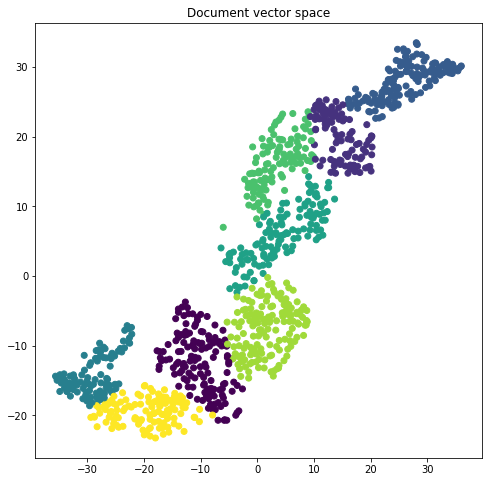

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.scatter(tsne_space[:,0], tsne_space[:,1], c=[tup[1] for tup in clustered_tokens])
plt.title('Document vector space')
plt.show()